In [1]:
# Treatment train - RO (RPT1)
# Power consumption vs recovery
# PV surrogate model
# Show PV+RO results :  We want higher recovery
# RPT-ZLD
# Show functions adding MD and MEC to flowsheet
# MD has high thermal energy requirements (show plots # agg heat and electricity sweep)
# Build CST surrogate
# Present the results % solar energy sweep

In [11]:
# Relevant Imports
from IPython.display import Image, HTML, clear_output
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from notebook.services.config import ConfigManager

cm = ConfigManager()
cm.update(
    "livereveal",
    {
        "width": 1400,
        "height": 768,
        "scroll": True,
    },
)

{'width': 1400, 'height': 768, 'scroll': True}

In [12]:
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

from watertap.core.util.model_diagnostics.infeasible import *
from watertap.core.util.initialization import *

from pyomo.environ import ConcreteModel, assert_optimal_termination
from pyomo.util.calc_var_value import calculate_variable_from_constraint as cvc

from idaes.core import FlowsheetBlock, UnitModelCostingBlock
from idaes.core.util.model_statistics import *

from watertap.core.solvers import get_solver

from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.sweep_functions.results_dict import *
from pyomo.environ import (
    value,
)

from idaes.core.util.model_statistics import degrees_of_freedom

from IPython.display import clear_output
from watertap_contrib.reflo.flowsheets.KBHDP import *

plt.rcParams["axes.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 14

cwd = %pwd

solver = get_solver()

In [13]:
def pv_plots(m):
    rd = build_results_dict(m)

    electricity_annual_model = list()
    electricity_annual_error = list()
    electricity_annual_error_rel = list()

    land_req_model = list()
    land_req_error = list()
    land_req_error_rel = list()

    for row in m.fs.pv.data.iterrows():
        m.fs.pv.system_capacity.fix(row[1].system_capacity)

        results = solver.solve(m, tee=False)
        assert_optimal_termination(results)
        electricity_annual_model.append(value(m.fs.pv.electricity_annual))
        electricity_annual_error.append(
            value(m.fs.pv.electricity_annual) - row[1].electricity_annual
        )
        electricity_annual_error_rel.append(
            100
            * (value(m.fs.pv.electricity_annual) - row[1].electricity_annual)
            / row[1].electricity_annual
        )
        land_req_model.append(value(m.fs.pv.land_req))
        land_req_error.append(value(m.fs.pv.land_req) - row[1].land_req)
        land_req_error_rel.append(
            100 * (value(m.fs.pv.land_req) - row[1].land_req) / row[1].land_req
        )
    #     rd = results_dict_append(m, rd)
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
    axs[0][0].scatter(
        m.fs.pv.data.electricity_annual,
        electricity_annual_model,
        marker="x",
    )
    axs[0][0].plot(
        [0, max(m.fs.pv.data.electricity_annual)],
        [0, max(m.fs.pv.data.electricity_annual)],
        color="black",
        linestyle="--",
    )
    axs[0][0].set(
        xlabel="Electrical Energy Generated (Data)",
        ylabel="Electrical Energy Generated (REFLO)",
    )

    axs[0][1].scatter(
        m.fs.pv.data.electricity_annual,
        electricity_annual_error_rel,
        marker="x",
        color="k",
    )
    axs[0][1].plot(
        m.fs.pv.data.electricity_annual,
        [0 for _ in m.fs.pv.data.electricity_annual],
        color="black",
        linestyle="--",
    )
    axs[0][1].set(xlabel="Electrical Energy Generated (Data)", ylabel="% Error")

    axs[1][0].scatter(
        m.fs.pv.data.land_req,
        land_req_model,
        color="red",
        marker="x",
    )
    axs[1][0].plot(
        [0, max(m.fs.pv.data.land_req)],
        [0, max(m.fs.pv.data.land_req)],
        color="black",
        linestyle="--",
    )
    axs[1][0].set(xlabel="Land Required (Data)", ylabel="Land Required (WaterTAP)")

    axs[1][1].scatter(m.fs.pv.data.land_req, land_req_error_rel, marker="x", color="k")
    axs[1][1].plot(
        m.fs.pv.data.land_req,
        [0 for _ in m.fs.pv.data.land_req],
        color="black",
        linestyle="--",
    )
    axs[1][1].set(xlabel="Land Required (Data)", ylabel="% Error")
    fig.tight_layout()

In [14]:
def cst_plots(m):
    heat_annual_model = list()
    heat_annual_error = list()
    heat_annual_error_rel = list()

    electricity_annual_model = list()
    electricity_annual_error = list()
    electricity_annual_error_rel = list()

    for row in m.fs.cst.data.iterrows():

        m.fs.cst.system_capacity.fix(row[1].system_capacity)
        m.fs.cst.hours_storage.fix(row[1].hours_storage)
        m.fs.cst.temperature_loop.set_value(row[1].temperature_loop)
        m.fs.cst.initialize()

        try:
            results = solver.solve(m, tee=False)
        except:
            print_infeasible_constraints(m)
            assert False
        assert_optimal_termination(results)
        heat_annual_model.append(value(m.fs.cst.heat_annual))
        electricity_annual_model.append(value(m.fs.cst.electricity_annual))
        heat_annual_error.append(value(m.fs.cst.heat_annual) - row[1].heat_annual)
        electricity_annual_error.append(
            value(m.fs.cst.electricity_annual) - row[1].electricity_annual
        )
        heat_annual_error_rel.append(
            100
            * (value(m.fs.cst.heat_annual) - row[1].heat_annual)
            / row[1].heat_annual
        )
        electricity_annual_error_rel.append(
            100
            * (value(m.fs.cst.electricity_annual) - row[1].electricity_annual)
            / row[1].electricity_annual
        )
    #         rd = results_dict_append(m, rd)

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(9, 7))
    axs[0][0].scatter(
        m.fs.cst.data.heat_annual,
        heat_annual_model,
        label="Heat Annual Model",
        marker="x",
    )
    axs[0][0].plot(
        [0, max(m.fs.cst.data.heat_annual)],
        [0, max(m.fs.cst.data.heat_annual)],
        color="black",
        linestyle="--",
    )
    axs[0][0].set(
        xlabel="Thermal Energy Generated (Data)",
        ylabel="Thermal Energy Generated (WaterTAP)",
    )

    axs[0][1].scatter(
        m.fs.cst.data.heat_annual, heat_annual_error_rel, marker="x", color="k"
    )
    axs[0][1].plot(
        m.fs.cst.data.heat_annual,
        [0 for _ in m.fs.cst.data.heat_annual],
        color="black",
        linestyle="--",
    )
    axs[0][1].set(xlabel="Annual Heat Energy (Data)", ylabel="% Error")
    axs[1][0].scatter(
        m.fs.cst.data.electricity_annual,
        electricity_annual_model,
        color="red",
        marker="x",
    )
    axs[1][0].plot(
        [0, max(m.fs.cst.data.electricity_annual)],
        [0, max(m.fs.cst.data.electricity_annual)],
        color="black",
        linestyle="--",
    )
    axs[1][0].set(
        xlabel="Electric Power Consumed (Data)",
        ylabel="Electric Power Consumed (WaterTAP)",
    )

    axs[1][1].scatter(
        m.fs.cst.data.electricity_annual,
        heat_annual_error_rel,
        label="Electricity Annual Model",
        marker="x",
        color="k",
    )
    axs[1][1].plot(
        m.fs.cst.data.electricity_annual,
        [0 for _ in m.fs.cst.data.electricity_annual],
        label="Electricity Annual Model",
        color="black",
        linestyle="--",
    )
    axs[1][1].set(xlabel="Electric Power Consumed (Data)", ylabel="% Error")
    fig.tight_layout()

<h1>Demonstration of WaterTAP-REFLO Framework</h1>

<div 
    style=
     "max-height:800px; 
      overflow-y: auto;">
    
Contents:
<ul>     
<li>Structure of a flowsheet in WaterTAP-REFLO</li>
<li>Comparison of treatment trains</li>   
<ul>    
    <li>Reverse osmosis treatment train</li>
    <li>Reverse osmosis treatment train with photovoltaic system</li>
    <li>Reverse osmosis with thermal desalination to achieve zero-liquid discharge</li>  
</ul>     
<li>Creating solar surrogate models</li>
    
</div>

Integrated system flowsheet development workflow in WaterTAP-REFLO

Step 1: Build the Treatment Flowsheet <br>
The Treatment costing package can be used to optimize the water treatment design and LCOW
<img src="figures/slides/Slide1.jpeg" width=1200 height=1200>

Step 2: Add the Energy Components to the Flowsheet <br>
The Energy costing package can be used to determine the annual energy generation
<img src="figures/slides/Slide2.jpeg" width=1200 height=1200>

Step 3: Add The REFLOSystem Costing package <br>
This connects the energy demand of the Water Treatment System to the Energy System 
to optimize the for a LCOT with energy integration

<center><img src="figures/slides/slide3.jpeg" width=1000 height=1000>

Reverse Osmosis Treatment System

<center><img src="figures/slides/slide7.jpeg" width=1000 height=1000><center>

Code Snippet of RO Flowsheet

In [6]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_kbhdp_ro import *


def build_demo_ro_system():
    m = ConcreteModel()
    m.db = REFLODatabase()
    m.fs = FlowsheetBlock(dynamic=False)

    # Define solutes of interest to track in the system
    m.fs.MCAS_properties = MCASParameterBlock(
        solute_list=[
            "Alkalinity_2-",
            "Ca_2+",
            "Cl_-",
            "Mg_2+",
            "K_+",
            "SiO2",
            "Na_+",
            "SO4_2-",
        ],
        material_flow_basis=MaterialFlowBasis.mass,
    )

    # Define other property packages
    m.fs.RO_properties = NaClParameterBlock()
    m.fs.UF_properties = WaterParameterBlock(solute_list=["tds", "tss"])

    # Build treatment units
    build_treatment(m)

    # Connect flow across treatment units
    add_connections(m)

    # Add water recovery and other constraints
    add_constraints(m)

    # Set operating conditions for treatment units
    set_treatment_operating_conditions(m)

    # Scale initialize treatment units
    apply_scaling(m)
    init_system(m)

    # Add costing for treatment units
    add_treatment_costing(m.fs.treatment)

    # Optimize the RO system
    optimize_system(
        m,
        ro_mem_area=20000,
        fixed_pressure=None,
        water_recovery=0.8,
        elec_price=None,
    )

    # Solve!
    results = solve(m)
    assert_optimal_termination(results)

    return m

RO Recovery Sweep

<img src="figures/results/kbhdp-ro-recovery-sweep.png" width=45% style="display:inline-block;"/> 
<img src="figures/results/kbhdp-ro-energy.png" width=45% style="display:inline-block;"/>

Surrogate Models for Solar Energy

Generate data

In [ ]:
import numpy as np
from watertap_contrib.reflo.solar_models.surrogate import generate_pv_data

weather_file = "el_paso_texas-KBHDP-weather.csv" 

pv_data = generate_pv_data(
    system_capacities=np.linspace(500, 2500, 100),
    pysam_model_config="FlatPlatePVSingleOwner",
    save_data=True,
    use_multiprocessing=True,
    processes=8,
    dataset_filename="pv_surrogate_data.pkl",
    weather_file=weather_file,
    tech_config_file=None,
    grid_config_file=None,
    rate_config_file=None,
    cash_config_file=None,
)
clear_output(wait=False)

Build PV Surrogate

In [20]:
from watertap_contrib.reflo.solar_models.surrogate.pv import PVSurrogate

input_variables = {
    "labels": ["system_capacity"],
    "bounds": {"system_capacity": [500, 2500]},
    "units": {"system_capacity": "kW"},
}
output_variables = {
    "labels": ["electricity_annual", "land_req"],
    "units": {"electricity_annual": "kWh/year", "land_req": "acre"},
}
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

m.fs.pv = PVSurrogate(
    dataset_filename="pv_surrogate_data.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=False,
    surrogate_filename_save="pv_surrogate_model.json",
)
clear_output(wait=False)

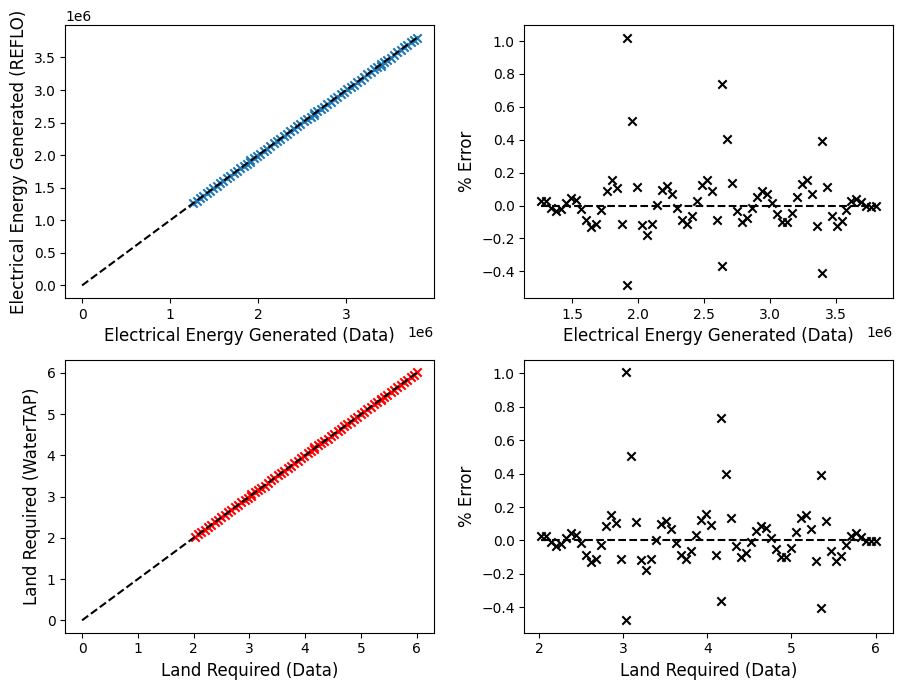

In [21]:
pv_plots(m)

Reverse Osmosis with Energy Integration

Code Snippet with Integration of Solar Energy (PV)

In [10]:
from watertap_contrib.reflo.code_demos.REFLO_demo.flowsheets.demo_kbhdp_ro import *


def build_demo_ro_pv_system():

    m = build_demo_ro_system()

    # Build energy unit models
    build_energy(m)

    # Set operating conditions for energy units
    set_energy_operating_conditions(m)

    # Scale energy units
    add_pv_scaling(m.fs.energy.pv)

    # Add costing for energy units
    add_energy_costing(m.fs.energy)

    # Add REFLOSystem costing
    add_system_costing(m)

    optimize_system(
        m,
        ro_mem_area=20000,
        fixed_pressure=None,
        water_recovery=0.8,
        grid_frac=0.5,
        elec_price=0.15,
    )

    m.fs.obj = Objective(expr=m.fs.costing.LCOT)

    results = solve(m)
    assert_optimal_termination(results)

    return m

Sweep across RO water recovery and Solar energy integration

<img src="figures/results/kbhdp-ro-solar-recovery-sweep.png" width=45% style="display:inline-block;"/>
<img src="figures/results/kbhdp-ro-solar-grid-sweep.png" width=45% style="display:inline-block;"/>

A sweep across DWI costs highlights its relative importance to other costs

<center><img src="figures/results/kbhdp-ro-dwi-sweep-2.png" width="50%"/> 

Reverse osmosis with thermal desalination to achieve zero-liquid discharge

<center><img src="figures/slides/slide8.jpeg" width=1000 height=1000><center>

Sweep across membrane distillation water recovery - High thermal energy demand

<img src="figures/results/kbhdp-mld-elec.png" width="32%" style="display:inline-block;"/>
<img src="figures/results/kbhdp-mld-heat.png" width="32%" style="display:inline-block;"/>

In [ ]:
# CST surrogate
# Users can decide the input to the surrogate model-300C
# Net metering and 24h storage of thermal system
# Accuracy of surrogate

Trough Surrogate

<center><img src="figures/slides/slide12.jpeg" width="80%" style="display:inline-block;"/><center>

Generate trough data

In [ ]:
import numpy as np
from watertap_contrib.reflo.solar_models.surrogate import generate_trough_data

weather_file = "el_paso_texas-KBHDP-weather.csv"

trough_data = generate_trough_data(
    system_capacities=np.linspace(1, 50, 100),
    hours_storages=[3, 12, 24],
    temperatures_loop=[300],
    weather_file=weather_file,
    save_data=True,
    use_multiprocessing=True,
    dataset_filename="trough_data.pkl",
)

Trough surrogate model

In [18]:
from watertap_contrib.reflo.solar_models.surrogate.trough.trough_surrogate import (
    TroughSurrogate,
)
input_bounds = dict(
    system_capacity=[10, 50],
    hours_storage=[12, 24]
)
input_units = dict(
    system_capacity="MW", hours_storage="hour"
)
input_variables = {
    "labels": ["system_capacity", "hours_storage"],
    "units": input_units,
}

output_units = dict(
    heat_annual="kWh/year",
    electricity_annual="kWh/year",
    total_aperture_area="m**2",
)
output_variables = {
    "labels": ["heat_annual", "electricity_annual", "total_aperture_area"],
    "units": output_units,
}
trough_dict = dict(
    dataset_filename="trough_surrogate_data.pkl",
    input_variables=input_variables,
    output_variables=output_variables,
    scale_training_data=True,
)

m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
m.fs.cst = TroughSurrogate(**trough_dict)
clear_output(wait=False)


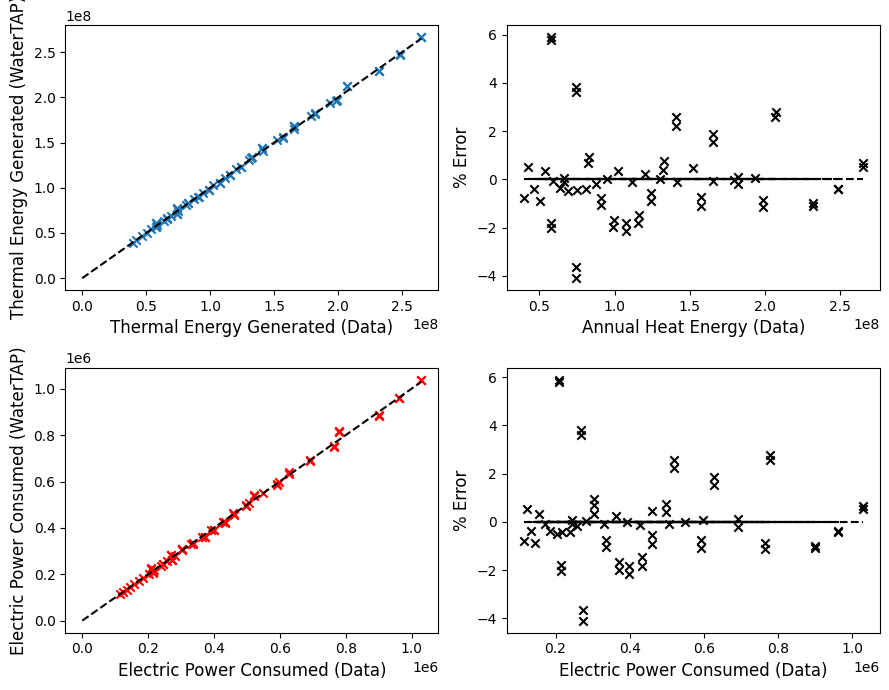

In [10]:
cst_plots(m)

ZLD code snippet

In [ ]:
from watertap_contrib.reflo.flowsheets.KBHDP.KBHDP_ZLD import *


def build_demo_ro_zld_system(Qin=4, ro_recovery=0.8, md_water_recovery=0.7):

    # Build the reverse osmosis flowsheet
    m = build_zld_ro(ro_recovery=ro_recovery, Qin=Qin)

    # Add the membrane distillation unit model
    add_zld_md(m, md_water_recovery=md_water_recovery)

    results = solve(m)
    assert_optimal_termination(results)

    # Add the multi-effect crystallizer unit model
    add_zld_mec(m)

    # Connect all product streams from the unit models
    add_product_stream(m)

    # Add energy unit models - PV and CST
    build_energy(m)

    results = solve(m.fs.treatment.mec)
    assert_optimal_termination(results)
    results = solve(m)
    assert_optimal_termination(results)

    # Add treatment costing
    add_treatment_costing(m.fs.treatment, heat_price=0, electricity_price=0)
    results = solve(m)
    assert_optimal_termination(results)

    # Add REFLOSystem costing
    add_system_costing(m)
    m.fs.energy.cst.unit.system_capacity.unfix()
    m.fs.energy.pv.unit.system_capacity.unfix()

    # Add objective function to optimize the LCOT
    m.fs.obj = Objective(expr=m.fs.costing.LCOT)

    iscale.calculate_scaling_factors(m)

    results = solve(m)
    assert_optimal_termination(results)

    # Update grid fraction of electricity
    m.fs.costing.frac_heat_from_grid.fix(0.9)
    m.fs.costing.frac_elec_from_grid.fix(0.5)

    results = solve(m)
    assert_optimal_termination(results)

    # Update grid fraction of heat
    m.fs.costing.frac_heat_from_grid.fix(0.5)

    # Solve!
    results = solve(m)
    assert_optimal_termination(results)

    return m

Sweep across solar integration fraction

<img src="figures/results/kbhdp-zld-solar-grid-sweep.png" width="35%" style="display:inline-block;">
<img src="figures/results/kbhdp_zld_tornado_plots.png" width="55%" style="display:inline-block;">